In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.misc import derivative
from matplotlib import rc

import dm_density_profiles as dmd
import cgs as cgs

import df as df

import time

using cgs py


In [2]:
NFW = dmd.general_dm_profile('NFW')
NFW.set_params(profile_shape_params=[1.0,3.0,1.0])
NFW.set_params(M_vir = 1.0E12 * cgs.Msun, r_vir = 240.0 * cgs.kpc)
NFW.set_params(r_decay = 0.1*NFW.r_vir, r_s = (1.0/12.0)*NFW.r_vir)

In [3]:
NFW_DF = df.DF(NFW)

#N_DM = 1.0E4
#M_DM = NFW.M_vir / N_DM


In [4]:
# find the range of the potential
r = np.linspace(0.0,1000.0,100.0)*cgs.kpc

rel_pot = NFW_DF.relative_potential(r)

# and pick a range of velocities
v = np.linspace(0.0,500.0 * cgs.km,100.0)
v_sqr = v*v

evals_low = rel_pot - np.min(0.5*v_sqr)
evals_high = rel_pot - np.max(0.5*v_sqr)

print np.min(evals_low), np.max(evals_low)
print np.min(evals_high), np.max(evals_high)

print np.min(rel_pot), np.max(rel_pot)

5.14896598414e+13 1.23779617229e+15
-1.19851034016e+15 -1.22038277136e+13
5.14896598414e+13 1.23779617229e+15


In [5]:
df_filename = 'NFW_500.dat'

load_df = False

In [6]:
if load_df:

    f = NFW_DF.load_df(df_filename)
    
else:
    start = time.time()

    f = NFW_DF.compute(500, filename = df_filename)

    end = time.time()
    print "run time ", (end-start)/60.0, end-start
    
    # write to file
    #outf = open(df_filename,'w')
    #for i in np.arange(np.size(NFW_DF.f)):
    #    outf.write("%.8E %.8E\n"%(NFW_DF.E[i],NFW_DF.f[i]))
    #outf.close()

    
f_analytical = df.hernquist_df(NFW_DF.E, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)

000 Computing value for E = 2.145E+11  - f = 0.000E+00
001 Computing value for E = 2.183E+11  - f = 0.000E+00
002 Computing value for E = 2.221E+11  - f = 0.000E+00
003 Computing value for E = 2.260E+11  - f = 0.000E+00
004 Computing value for E = 2.300E+11  - f = 0.000E+00
005 Computing value for E = 2.340E+11  - f = 0.000E+00
006 Computing value for E = 2.381E+11  - f = 0.000E+00
007 Computing value for E = 2.423E+11  - f = 0.000E+00
008 Computing value for E = 2.465E+11  - f = 0.000E+00
009 Computing value for E = 2.508E+11  - f = 0.000E+00
010 Computing value for E = 2.552E+11  - f = 0.000E+00
011 Computing value for E = 2.597E+11  - f = 0.000E+00
012 Computing value for E = 2.642E+11  - f = 0.000E+00
013 Computing value for E = 2.688E+11  - f = 0.000E+00
014 Computing value for E = 2.735E+11  - f = 0.000E+00
015 Computing value for E = 2.783E+11  - f = 0.000E+00
016 Computing value for E = 2.832E+11  - f = 0.000E+00
017 Computing value for E = 2.882E+11  - f = 0.000E+00
018 Comput

dm_density_profiles.py:252: RuntimeWarning: invalid value encountered in true_divide
  second_deriv = self.first_derivative(r) * self.first_derivative(r) / self.density(r)+\


/home/emerick/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


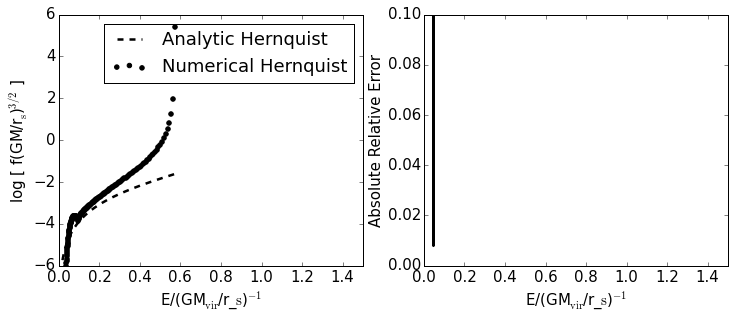

In [7]:
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)

error = (NFW_DF.f - f_analytical)/f_analytical

error = np.abs(error)

fsize = 15
#rc('text', usetex=True)
rc('font', size=fsize)#, ftype=42)
line_width = 2.5

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4.5)
#ax1 = plt.subplot(211)

ax[0].scatter(NFW_DF.E*E_const, np.log10(NFW_DF.f * f_const), label = "Numerical Hernquist",color='black')

#ax[0].plot(NFW_DF.E*E_const, np.log10(NFW_DF.f * f_const), lw=line_width, label = "Numerical Hernquist",color='black',ls='-')
ax[0].plot(NFW_DF.E*E_const, np.log10(f_analytical * f_const), lw=line_width, label="Analytic Hernquist", color='black',ls='--')
ax[0].set_ylabel(r'log [ f(GM/r$_{\rm{s}}$)$^{3/2}$ ]')
ax[0].set_ylim(-6,6)
ax[0].legend(loc='best')
#ax2 = plt.subplot(221)

ax[1].plot(NFW_DF.E * E_const, error, lw = line_width, color='black')
ax[1].set_ylabel(r'Absolute Relative Error')
for a in ax:
    a.set_xlim(0.0,1.5)
    a.set_xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
ax[1].set_ylim(0.0,0.10)

fig.savefig('NFW_DF.png')

nan


df.py:226: RuntimeWarning: divide by zero encountered in log10
  log_f = np.log10(self.f)


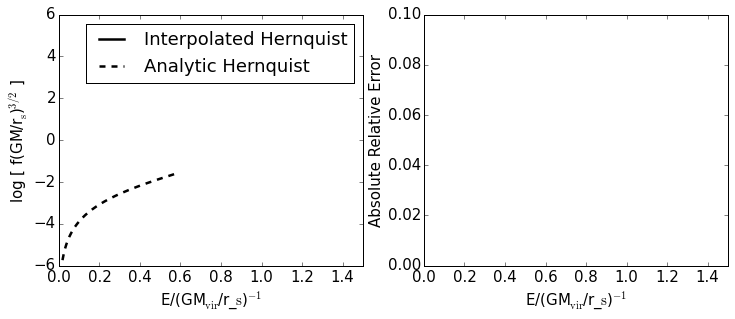

In [8]:
# now repeat the above, but with the spline interpolation at many E points:
E_array = np.linspace(np.min(NFW_DF.E), np.max(NFW_DF.E), 1000.0)

f_spline     = NFW_DF.interpolate_f(E_array, s = 0)
f_analytical = df.hernquist_df(E_array, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)

####
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)

error = (f_spline - f_analytical)/f_analytical

error = np.abs(error)

fsize = 15
#rc('text', usetex=True)
rc('font', size=fsize)#, ftype=42)
line_width = 2.5

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4.5)
#ax1 = plt.subplot(211)

ax[0].plot(E_array*E_const, np.log10(f_spline * f_const), lw=line_width, label = "Interpolated Hernquist",color='black',ls='-')
ax[0].plot(E_array*E_const, np.log10(f_analytical * f_const), lw=line_width, label="Analytic Hernquist", color='black',ls='--')
ax[0].set_ylabel(r'log [ f(GM/r$_{\rm{s}}$)$^{3/2}$ ]')
ax[0].set_ylim(-6,6)
ax[0].legend(loc='best')
#ax2 = plt.subplot(221)

ax[1].plot(E_array * E_const, error, lw = line_width, color='black')
ax[1].set_ylabel(r'Absolute Relative Error')
for a in ax:
    a.set_xlim(0.0,1.5)
    a.set_xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
ax[1].set_ylim(0.0,0.10)

fig.savefig('NFW_interpolated.png')
print np.max(error[:-1])

/home/emerick/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


(0.0, 0.1)

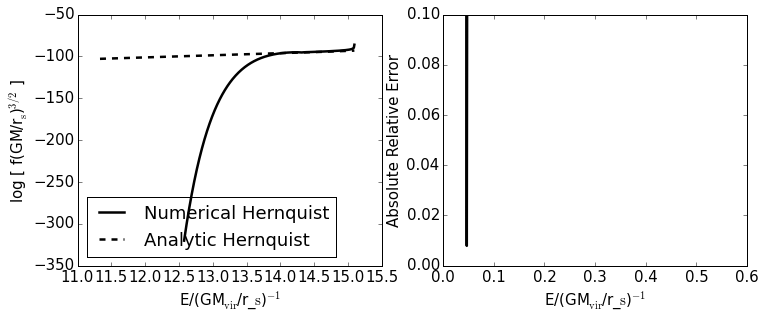

In [9]:
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)
f_analytical = df.hernquist_df(NFW_DF.E, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)
error = (NFW_DF.f - f_analytical)/f_analytical

error = np.abs(error)

fsize = 15
#rc('text', usetex=True)
rc('font', size=fsize)#, ftype=42)
line_width = 2.5

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4.5)
#ax1 = plt.subplot(211)

ax[0].plot(np.log10(NFW_DF.E), np.log10(NFW_DF.f), lw=line_width, label = "Numerical Hernquist",color='black',ls='-')
ax[0].plot(np.log10(NFW_DF.E), np.log10(f_analytical), lw=line_width, label="Analytic Hernquist", color='black',ls='--')
ax[0].set_ylabel(r'log [ f(GM/r$_{\rm{s}}$)$^{3/2}$ ]')
ax[0].legend(loc='best')
#ax2 = plt.subplot(221)

ax[1].plot(NFW_DF.E * E_const, error, lw = line_width, color='black')
ax[1].set_ylabel(r'Absolute Relative Error')
for a in ax:
    a.set_xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
ax[1].set_ylim(0.0,0.10)

#fig.savefig('Hernquest_DF.png')

[]

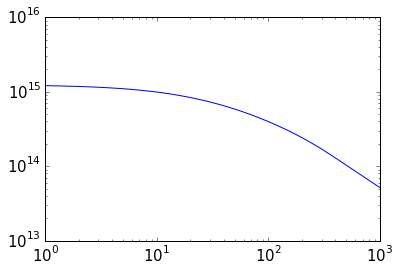

In [10]:
r = np.logspace(0.0,3.0,100.0)*cgs.kpc
rel_pot = NFW_DF.relative_potential(r)

plt.plot(r/cgs.kpc, rel_pot)
plt.loglog()

[]

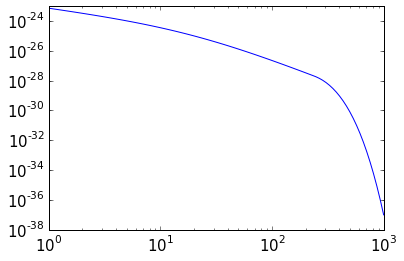

In [11]:
r = np.logspace(0.0,3.0,100.0)*cgs.kpc
density = NFW_DF.dprof.density(r)
plt.plot(r/cgs.kpc, density)
plt.loglog()

[]

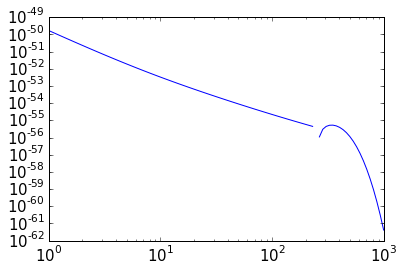

In [12]:
deriv =  NFW_DF._d2rho_dPsi2(r)
plt.plot(r/cgs.kpc,deriv)
plt.loglog()